### Advanced task: image captioning with visual attention

![img](https://i.imgur.com/r3r0fS4.jpg)

__This task__ walks you through all steps required to build an attentive image-to-captioning system. Except this time, there's no `<YOUR CODE HERE>`'s. You write all the code.

You are free to approach this task in any way you want. Follow our step-by-step guide or abandon it altogether. Use the notebook or add extra .py files (remember to add them to your anytask submission). The only limitation is that your code should be readable and runnable top-to-bottom.



In [1]:
import json
import re
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from tqdm import tqdm

%matplotlib inline

In [2]:
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

from torchvision.datasets import coco
from torchvision import transforms

### Step 1: image preprocessing (5 pts)

First, you need to prepare images for captioning. Just like in the basic notebook, you are going to use a pre-trained image classifier from the model zoo. Let's go to the [`preprocess_data.ipynb`](./preprocess_data) notebook and change a few things there. This stage is mostly running the existing code with minor modiffications.

1. Download the data someplace where you have enough space. You will need around 100Gb for the whole thing.
2. Pre-compute and save Inception activations at the layer directly __before the average pooling__.
 - the correct shape should be `[batch_size, 2048, 8, 8]`. Your LSTM will attend to that 8x8 grid.


__Note 1:__ Inception is great, but not the best model in the field. If you have enough courage, consider using ResNet or DenseNet from the same model zoo. Just remember that different models may require different image preprocessing.

__Note 2:__ Running this model on CPU may take days. You can speed things up by processing data in parts using colab + google drive. Here's how you do that: https://colab.research.google.com/notebooks/io.ipynb

In [ ]:
#!curl http://images.cocodataset.org/zips/train2017.zip > train2017.zip
#!curl http://images.cocodataset.org/zips/val2017.zip > val2017.zip
#!curl http://images.cocodataset.org/annotations/annotations_trainval2017.zip > annotations_trainval2017.zip

In [ ]:
# !unzip annotations_trainval2017.zip
# !unzip train2017.zip > log
# !unzip val2017.zip > log

In [3]:
!ls train2017 | wc -l
!ls val2017 | wc -l

118287
5000


In [4]:
# !wget https://raw.githubusercontent.com/yandexdataschool/Practical_DL/spring20/homework04/beheaded_inception3.py

In [3]:
transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
])

coco_train = coco.CocoCaptions('train2017/',
                               'annotations/captions_train2017.json',
                               transform=transform)

train_loader = torch.utils.data.DataLoader(dataset=coco_train, batch_size=32, shuffle=False, num_workers=4)

coco_val = coco.CocoCaptions('val2017/',
                             'annotations/captions_val2017.json',
                             transform=transform)

val_loader = torch.utils.data.DataLoader(dataset=coco_val, batch_size=32, shuffle=False, num_workers=4)

loading annotations into memory...
Done (t=1.03s)
creating index...
index created!
loading annotations into memory...
Done (t=0.19s)
creating index...
index created!


In [4]:
from beheaded_inception3 import BeheadedInception3
from torch.utils.model_zoo import load_url

model= BeheadedInception3(transform_input=True)

inception_url = 'https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth'
model.load_state_dict(load_url(inception_url))

model = model.train(False).cuda()

In [5]:
def transform_data(data_loader, data_len, batch_size):
    vectors_before_pool = torch.empty((data_len, 2048, 8, 8), dtype=torch.float32, device='cpu')
    captions = []

    with torch.no_grad():
        for i, (img_batch, capt_batch) in tqdm(enumerate(data_loader), total=data_len // batch_size + 1):
            img_batch = Variable(img_batch, volatile=True)
            vec_batch_for_attn = model(img_batch.cuda())[0].to(device='cpu')
            vectors_before_pool[i * batch_size: i * batch_size + vec_batch_for_attn.shape[0]] = vec_batch_for_attn

            capt_batch = list(zip(*capt_batch))
            captions.extend(capt_batch)
    
    return vectors_before_pool, captions

In [8]:
train_emb, train_captions = transform_data(train_loader, len(coco_train), 32)
train_emb.shape, len(train_captions)

  0%|          | 0/3697 [00:00<?, ?it/s]/home/gerasimov_as/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys
100%|██████████| 3697/3697 [07:55<00:00,  7.77it/s]


(torch.Size([118287, 2048, 8, 8]), 118287)

In [10]:
torch.save(train_emb, 'data/train_emb_tensor.pt')

In [6]:
val_emb, val_captions = transform_data(val_loader, len(coco_val), 32)
val_emb.shape, len(val_captions)

  0%|          | 0/157 [00:00<?, ?it/s]/home/gerasimov_as/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys
100%|██████████| 157/157 [00:20<00:00,  7.58it/s]


(torch.Size([5000, 2048, 8, 8]), 5000)

In [7]:
torch.save(val_emb, 'data/val_emb_tensor.pt')

In [ ]:
def save_embeddings(embs, dirpath):
    for i, emb in tqdm(enumerate(embs)):
        np.save(dirpath + f'/emb_{i}.npy', np.asarray(emb))

In [ ]:
save_embeddings(train_emb, './data/train/images')

In [ ]:
save_embeddings(val_emb, './data/val/images')

### Step 2: sub-word tokenization (5 pts)

While it is not strictly necessary for image captioning, you can generally improve generative text models by using sub-word units. There are several sub-word tokenizers available in the open-source (BPE, Wordpiece, etc).

* __[recommended]__ BPE implementation you can use: [github_repo](https://github.com/rsennrich/subword-nmt). 
* Theory on how it works: https://arxiv.org/abs/1508.07909
* We recommend starting with __4000 bpe rules__.
* The result@@ ing lines will contain splits for rare and mis@@ typed words like this: ser@@ endi@@ pity


In [ ]:
import subword_nmt.apply_bpe
import subword_nmt.learn_bpe
from nltk.tokenize import TweetTokenizer

In [ ]:
def learn_bpes(captions, bpe_count=4000, bpe_filename='data/bpe.txt'):
    tokenizer = TweetTokenizer()
    
    tokenized_captions = [[' '.join(filter(len, tokenizer.tokenize(cap.lower()))) 
                               for cap in img_captions]
                                   for img_captions in tqdm(captions)]
    
    with open('tmp_captions.txt', 'w') as tmp:
        for img_captions in tqdm(tokenized_captions):
            for cap in img_captions:
                print(cap, file=tmp)
                
    with open('tmp_captions.txt', 'r') as tmp, open(bpe_filename, 'w') as bpes:
        subword_nmt.learn_bpe.learn_bpe(tmp, bpes, num_symbols=bpe_count)

In [ ]:
learn_bpes(train_captions)

In [ ]:
!cat data/bpe.txt | wc -l
!head -n 20 data/bpe.txt

In [ ]:
def apply_bpes(captions, bpe_filename='data/bpe.txt'):
    tokenizer = TweetTokenizer()
    
    tokenized_captions = [[' '.join(filter(len, tokenizer.tokenize(cap.lower()))) 
                               for cap in img_captions]
                                   for img_captions in tqdm(captions)]
    
    with open(bpe_filename, 'r') as bpe_rules:
        bpeizer = subword_nmt.apply_bpe.BPE(bpe_rules)
        
        return [[bpeizer.segment(cap)
                     for cap in img_captions]
                         for img_captions in tqdm(tokenized_captions)]

In [ ]:
train_bpe = apply_bpes(train_captions)
len(train_bpe)

In [ ]:
for l in train_captions[0]:
    print(l)
    
print()

for l in train_bpe[0]:
    print(l)

In [ ]:
val_bpe = apply_bpes(val_captions)
len(val_bpe)

In [ ]:
for l in val_captions[1]:
    print(l)
    
print()

for l in val_bpe[1]:
    print(l)

In [ ]:
with open('data/train_caps.json', 'w') as f:
    json.dump(train_captions, f)
with open('data/train_bpe.json', 'w') as f:
    json.dump(train_bpe, f)
with open('data/val_caps.json', 'w') as f:
    json.dump(val_captions, f)
with open('data/val_bpe.json', 'w') as f:
    json.dump(val_bpe, f)

In [3]:
train_emb = torch.load('data/train_emb_tensor.pt')
val_emb = torch.load('data/val_emb_tensor.pt')

with open('data/train_bpe.json', 'r') as f:
    train_bpe = json.load(f)
with open('data/val_bpe.json', 'r') as f:
    val_bpe = json.load(f)

In [4]:
print(train_emb.shape)
print(val_emb.shape)
print(len(train_bpe))
print(len(val_bpe))

torch.Size([118287, 2048, 8, 8])
torch.Size([5000, 2048, 8, 8])
118287
5000


In [5]:
start_token = '#START#'
end_token = '#END#'
pad_token = '#PAD#'

def preporcess_captions(captions):
    vocab = set([start_token, end_token, pad_token])
    
    transformed_captions = []
    for img_captions in captions:
        img_transformed_captions = []
        for cap in img_captions:
            sentence = cap.split(' ')
            vocab.update(sentence)
            img_transformed_captions.append([start_token] + sentence + [end_token])
        transformed_captions.append(img_transformed_captions)
            
    vocab = list(vocab)
    word_to_index = {w: i for i, w in enumerate(vocab)}
    return transformed_captions, vocab, word_to_index

In [6]:
train_captions, vocab, word_to_index = preporcess_captions(train_bpe)
n_tokens = len(vocab)

In [7]:
n_tokens

4097

In [8]:
val_captions, _, _ = preporcess_captions(val_bpe)

In [9]:
start_ix = word_to_index[start_token]
end_ix = word_to_index[end_token]
pad_ix = word_to_index[pad_token]

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    max_len = max_len or max(map(len,sequences))
    
    matrix = np.zeros((len(sequences), max_len), dtype='int32') + pad_ix
    for i,seq in enumerate(sequences):
        row_ix = [word_to_index[word] for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix

In [10]:
as_matrix(train_captions[1234])

array([[2419, 2644,   94,  572, 4029, 2888,  382, 3764,  312, 1340, 2033,
        2644, 2554, 1315, 3326, 2094, 2094],
       [2419, 2644, 2007,  616,  675, 2391,  753,  617, 1205, 2644, 1696,
         854, 3326, 2094, 2094, 2094, 2094],
       [2419, 1696, 1499, 1166,  312, 1888, 3203, 2391,  753,  572, 1315,
        3326, 2094, 2094, 2094, 2094, 2094],
       [2419, 1045, 3203, 2391, 2352,  616, 2909, 4029, 1166,  312, 2391,
         753,  617, 1315, 3326, 2094, 2094],
       [2419, 2644, 1045, 2214, 3203, 2391, 2644, 2691, 2543, 2827, 3788,
        1888, 2391,  753,  572, 1315, 3326]], dtype=int32)

### Step 3: define attentive decoder (5 pts)

Your model works similarly to the normal image captioning decoder, except that it has an additional mechanism for peeping into image at each step. We recommend implementing this mechanism as a separate Attention layer, inheriting from `nn.Module`. Here's what it should do:

![img](https://camo.githubusercontent.com/1f5d1b5def5ab2933b3746c9ef51f4622ce78b86/68747470733a2f2f692e696d6775722e636f6d2f36664b486c48622e706e67)


__Input:__ 8x8=64 image encoder vectors $ h^e_0, h^e_1, h^e_2, ..., h^e_64$ and a single decoder LSTM hidden state $h^d$.

* Compute logits with a 2-layer neural network with tanh activation (or anything similar)

$$a_t = linear_{out}(tanh(linear_{e}(h^e_t) + linear_{d}(h_d)))$$

* Get probabilities from logits, 

$$ p_t = {{e ^ {a_t}} \over { \sum_\tau e^{a_\tau} }} $$

* Add up encoder states with probabilities to get __attention response__
$$ attn = \sum_t p_t \cdot h^e_t $$

You can now feed this $attn$ to the decoder LSTM in concatenation with previous token embeddings.

__Note 1:__ If you need more information on how attention works, here's [a class in attentive seq2seq](https://github.com/yandexdataschool/nlp_course/tree/master/week04_seq2seq) from the NLP course.

__Note 2:__ There's always a choice whether you initialize LSTM state with some image features or zeros. We recommend using zeros: it is a good way to debug whether your attention is working and it usually produces better-looking attention maps

In [11]:
class Attention(nn.Module):
    def __init__(self, enc_size, dec_size, hid_size, activ=nn.Tanh):
        super(Attention, self).__init__()
        
        self.enc_fc = nn.Linear(enc_size, hid_size)
        self.dec_fc = nn.Linear(dec_size, hid_size)
        self.out_fc = nn.Linear(hid_size, 1)
        self.activ = activ()

    def forward(self, enc, dec):
        enc_logits = self.enc_fc(enc)
        dec_logits = self.dec_fc(dec)[:, None, :]
        logits = self.out_fc(self.activ(enc_logits + dec_logits))[:, :, 0]
        probs = F.softmax(logits, dim=1)[:, :, None]
        attn = torch.sum(probs * enc, dim=1)

        return attn

In [12]:
class CaptionNet(nn.Module):
    def __init__(self, n_tokens=n_tokens, emb_size=128, hid_size=128,
                 lstm_units=256, cnn_feature_shape=(2048, 8, 8)):
        super(self.__class__, self).__init__()
        
        self.lstm_units = lstm_units
        
        self.emb = nn.Embedding(n_tokens, emb_size, padding_idx=pad_ix)
        
        cnn_feature_size = cnn_feature_shape[0]
        self.attn = Attention(enc_size=cnn_feature_size, dec_size=lstm_units, hid_size=hid_size)
        self.lstm = nn.LSTMCell(emb_size + cnn_feature_size, lstm_units)
        
        self.logits = nn.Linear(lstm_units, n_tokens)
        
    def forward(self, image_vectors, captions_ix):
        image_vectors = image_vectors.view((image_vectors.shape[0], image_vectors.shape[1], -1))\
                                     .transpose(1, 2)
        captions_emb = self.emb(captions_ix).transpose(0, 1)
        
        logits = []
        
        hid_state = torch.zeros((image_vectors.shape[0], self.lstm_units), device=image_vectors.device)
        cell_state = torch.zeros((image_vectors.shape[0], self.lstm_units), device=image_vectors.device)
        for cap in captions_emb:
            attn = self.attn(image_vectors, hid_state)
            lstm_input = torch.cat([cap, attn], dim=1)
            hid_state, cell_state = self.lstm(lstm_input, (hid_state, cell_state))
            logits.append(hid_state)
            
        logits = self.logits(torch.stack(logits, dim=1))
        
        return logits        

In [13]:
network = CaptionNet(n_tokens)

In [14]:
dummy_img_vec = torch.randn(len(train_captions[0]), 2048, 8, 8)
dummy_capt_ix = torch.tensor(as_matrix(train_captions[0]), dtype=torch.int64)

dummy_logits = network.forward(dummy_img_vec, dummy_capt_ix)

print('shape:', dummy_logits.shape)
assert dummy_logits.shape == (dummy_capt_ix.shape[0], dummy_capt_ix.shape[1], n_tokens)

shape: torch.Size([5, 14, 4097])


### Step 4: training

Up to 10 pts based on the model performance. 
The training procedure for your model is no different from the original non-attentive captioning from the base track: iterate minibatches, compute loss, backprop, use the optimizer.

Feel free to use the [`basic track notebook`](./homework04_basic_part2_image_captioning) for "inspiration" :)


In [15]:
def compute_loss(network, image_vectors, captions_ix):
    """
    :param image_vectors: torch tensor containing inception vectors. shape: [batch, cnn_feature_size]
    :param captions_ix: torch tensor containing captions as matrix. shape: [batch, word_i]. 
        padded with pad_ix
    :returns: scalar crossentropy loss (neg llh) loss for next captions_ix given previous ones
    """
    
    # captions for input - all except last cuz we don't know next token for last one.
    captions_ix_inp = captions_ix[:, :-1].contiguous()
    captions_ix_next = captions_ix[:, 1:].contiguous()
    
    # apply the network, get predictions for captions_ix_next
    logits_for_next = network.forward(image_vectors, captions_ix_inp)
    
    
    # compute the loss function between logits_for_next and captions_ix_next
    # Use the mask, Luke: make sure that predicting next tokens after EOS do not contribute to loss
    # you can do that either by multiplying elementwise loss by (captions_ix_next != pad_ix)
    # or by using ignore_index in some losses.
    
    loss = nn.functional.cross_entropy(logits_for_next.transpose(1, 2), captions_ix_next, ignore_index=pad_ix).reshape(1)
    
    return loss

In [16]:
dummy_loss = compute_loss(network, dummy_img_vec, dummy_capt_ix)

assert dummy_loss.shape == torch.Size([1]), 'loss must be scalar'
assert dummy_loss.data.numpy() > 0, "did you forget the 'negative' part of negative log-likelihood"

dummy_loss.backward()

assert all(param.grad is not None for param in network.parameters()), \
        'loss should depend differentiably on all neural network weights'

In [17]:
from random import choice

class CustomDataset(Dataset):
    def __init__(self, images, captions):
        assert len(images) == len(captions), 'images and captions must have same len'
        
        self.images = images
        self.captions = captions
        
    def __len__(self):
        return len(self.captions)
    
    def __getitem__(self, idx):
        return self.images[idx], choice(self.captions[idx])

In [18]:
BATCH_SIZE = 256

def collate_fn(batch):
    images = [x[0] for x in batch]
    captions = [x[1] for x in batch]
    return torch.stack(images, dim=0), torch.tensor(as_matrix(captions), dtype=torch.int64)

train_dataset = CustomDataset(train_emb, train_captions)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)

val_dataset = CustomDataset(val_emb, val_captions)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)

In [19]:
from beheaded_inception3 import beheaded_inception_v3
inception = beheaded_inception_v3().train(False).cuda()

In [41]:
def generate_caption(nnetwork, inception, image, caption_prefix=(start_token), 
                     t=1, sample=True, max_len=100):
    assert isinstance(image, np.ndarray) and np.max(image) <= 1\
           and np.min(image) >=0 and image.shape[-1] == 3
    
    with torch.no_grad():
        image = torch.tensor(image.transpose([2, 0, 1]), dtype=torch.float32).cuda()

        image_emb = inception(image[None])[0]
        caption_prefix = [caption_prefix]

        for _ in range(max_len):
            prefix_ix = as_matrix([caption_prefix])
            prefix_ix = torch.tensor(prefix_ix, dtype=torch.int64).cuda()
            next_word_logits = network.forward(image_emb, prefix_ix)[0, -1]
            next_word_probs = F.softmax(next_word_logits, dim=-1).cpu().data.numpy()

            assert len(next_word_probs.shape) == 1, 'probs must be one-dimensional'
            next_word_probs = next_word_probs ** t / np.sum(next_word_probs ** t) # apply temperature

            if sample:
                next_word = np.random.choice(vocab, p=next_word_probs) 
            else:
                next_word = vocab[np.argmax(next_word_probs)]

            caption_prefix.append(next_word)

            if next_word == "#END#":
                break
            
    return caption_prefix

def generate_captions(network, inception, image_filename, captions_num=10, t=1.):
    image = Image.open(image_filename)
    image = image.resize((299, 299))
    image = np.array(image, dtype=np.float32) / 255
    
    captions = [' '.join(generate_caption(network, inception, image, t=t, sample=False)[1:-1]), '']
    captions += [' '.join(generate_caption(network, inception, image, t=t)[1:-1]) for _ in range(captions_num)]
    captions = '\n'.join([re.sub('(@@ )|(@@ ?$)', '', x) for x in captions])
    
    return image, captions

In [34]:
from os import listdir
from tqdm.notebook import tqdm as ntqdm


def train(network, train_dataloader, val_dataloader, epoch_num=200, lr=1e-3,
          log_dir='./logs', model_path='./model.pth',
          num_val_generations=2, valdir='val2017', epoch_shift=0):
    
    logger = SummaryWriter(log_dir=log_dir)
    opt = torch.optim.Adam(network.parameters(), lr=lr)
    val_files = listdir(valdir)
    
    for epoch in ntqdm(range(epoch_shift, epoch_shift + epoch_num), leave=True):
        train_losses = []
        network.train()
        for image_embs, captions_ix in ntqdm(train_dataloader, leave=False):

            loss_t = compute_loss(network, image_embs.cuda(), captions_ix.cuda())
            opt.zero_grad()
            loss_t.backward()
            opt.step()

            train_losses.append(loss_t.item())

        logger.add_scalar('Loss/train', np.mean(train_losses), epoch)

        val_losses = []
        network.eval()
        with torch.no_grad():
            for image_embs, captions_ix in ntqdm(val_dataloader, leave=False):
                loss_t = compute_loss(network, image_embs.cuda(), captions_ix.cuda())
                val_losses.append(loss_t.item())

        logger.add_scalar('Loss/val', np.mean(val_losses), epoch)
        
        
        for i in range(num_val_generations):
            image, captions = generate_captions(network, inception, valdir + '/' + choice(val_files), t=2.)
            logger.add_image(f'Val/img{i}', image.transpose([2, 0, 1]), global_step=epoch)
            logger.add_text(f'Val/caption{i}', captions, global_step=epoch)

    network = network.cpu()
    torch.save(network.state_dict(), model_path)
    return network

In [28]:
for instance in list(tqdm._instances):
    tqdm._decr_instances(instance)

In [31]:
network = CaptionNet(n_tokens)

In [32]:
network = train(network.cuda(), train_dataloader, val_dataloader, epoch_num=100)

KeyboardInterrupt: 

In [35]:
network = train(network.cuda(), train_dataloader, val_dataloader, epoch_num=25, lr=1e-4, epoch_shift=36)

### Final step: show us what it's capable of! (5 pts)

The task is exactly the same as in the base track _(with the exception that you don't have to deal with salary prediction :) )_


__Task: Find at least 10 images to test it on.__

* Seriously, that's a part of the assignment. Go get at least 10 pictures for captioning
* Make sure it works okay on __simple__ images before going to something more complex
* Your pictures must feature both successful and failed captioning. Get creative :)
* Use photos, not animation/3d/drawings, unless you want to re-train CNN network on anime
* Mind the aspect ratio.

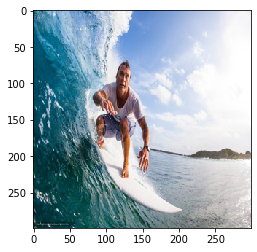

a man on a surfboard in the ocean .

a man in a wetsuit on a surfboard in the water .
the man is on the water riding a large wave .
a man on a surfboard in a body of water .
a young man is surfing on a wave in the ocean .
a young man on a surfboard in the ocean .
a man in a wet suit on a surfboard .
a man is surfing in the ocean with a surfboard .
a man is surfing on a large wave in the ocean .
a man riding a wave on a surfboard .
a man surfing on a white surfboard in the ocean


In [44]:
# !wget https://avatars.mds.yandex.net/get-pdb/49816/7291c336-6682-4341-9722-36284ab7da4d/s1200?webp=false -O data/test/image1.jpg
image, captions = generate_captions(network.cuda(), inception, 'data/test/image1.jpg', t=2.)
plt.imshow(image)
plt.show()
print(captions)

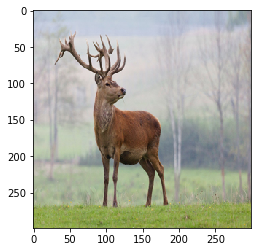

a giraffe standing in a field of grass .

a couple of giraffe standing next to each other
a zebra standing in a field of tall grass .
a group of three giraffe standing next to each other .
a close up of a giraffe in a field
a giraffe is walking through a dry grass field .
a close up of a zebra in a field
a couple of giraffe walking through a grassy field .
a group of deer standing in a field of grass .
a couple of giraffes that are standing in the grass .
a couple of giraffe standing in a field of tall grass .


In [46]:
# !wget https://avatars.mds.yandex.net/get-pdb/38069/26ad625d-f7b9-40cd-a269-c78b39e868e2/s1200?webp=false -O data/test/image2.jpg
image, captions = generate_captions(network.cuda(), inception, 'data/test/image2.jpg', t=2.)
plt.imshow(image)
plt.show()ф
print(captions)

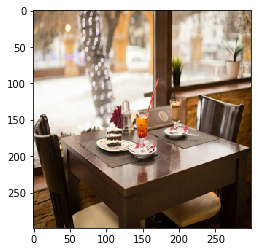

a table with a bunch of plates and cups on it

a table set with a cup of coffee and a flower in it .
a table with a bunch of food in it
a table with plates of food and other food
a table with a lot of food and bowls of food
a table with a cup and a table with a cup of coffee
a table with a bunch of plates and bowls of food .
a table with a bunch of food on it
a table with a bunch of plates and bowls of food
a table with chairs and a vase of flowers .
a table with a lot of food on it


In [47]:
# !wget https://avatars.mds.yandex.net/get-zen_doc/1707183/pub_5daecffed5bbc300ae439f4e_5daed878a660d700ad15d514/scale_1200 -O data/test/image3.jpg
image, captions = generate_captions(network.cuda(), inception, 'data/test/image3.jpg', t=2.)
plt.imshow(image)
plt.show()
print(captions)

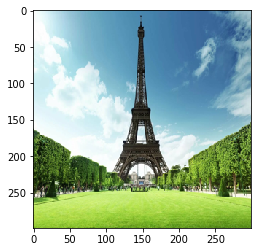

a tall clock tower in a field of grass .

a tall building with a clock on the top of it .
a tall tower with a clock on it
a large clock tower with a sky background
a clock tower is standing by a large church .
a clock tower in a park with a sky background
a tall tower with a clock on the side of it .
a large clock on a tower in a park .
a tall tower with a clock on it
a large clock tower is shown on the side of a road .
a large clock tower in the middle of a grassy field .


In [48]:
# !wget https://avatars.mds.yandex.net/get-pdb/1924971/35c200c6-5d6b-4c77-a26b-9d2fb3ed2997/s1200?webp=false -O data/test/image4.jpg
image, captions = generate_captions(network.cuda(), inception, 'data/test/image4.jpg', t=2.)
plt.imshow(image)
plt.show()
print(captions)

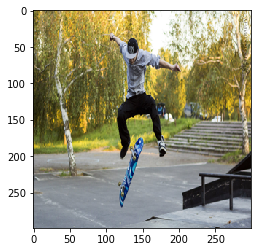

a man riding a skateboard on top of a cement block .

a man riding a skateboard on top of a cement block .
a man riding a skateboard on top of a cement walkway .
a skateboarder performs a trick on a skateboard .
a man riding a skateboard on top of a cement slab .
a skateboarder in mid air doing a trick .
a skateboarder is riding a skateboard at the top of a ramp .
a man riding a skateboard on top of a ramp .
a skateboarder jumping over a wooden rail in front of some trees .
a skateboarder is performing a trick on a skateboard .
a young man riding a skateboard on top of a cement bench .


In [81]:
# !wget https://avatars.mds.yandex.net/get-pdb/1101614/94141201-2163-485a-9432-6f3b762ec1a5/s1200?webp=false -O data/test/image5.jpg
image, captions = generate_captions(network.cuda(), inception, 'data/test/image5.jpg', t=2.)
plt.imshow(image)
plt.show()
print(captions)

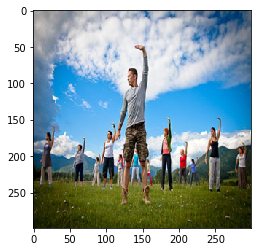

a man is throwing a frisbee in a grassy field .

a man throwing a frisbee in a grassy field .
a man is throwing a frisbee in a grassy area .
a man is playing frisbee in a park .
a man in a blue shirt playing frisbee in a park .
a man jumping up in the air with a frisbee in the background
a man throwing a frisbee in the grass .
a man throwing a frisbee in a grassy field .
a man is throwing a frisbee in a park .
a man playing frisbee on a lush green field .
a woman throwing a frisbee in a grassy field .


In [51]:
# !wget https://www.jv.ru/resize/article3detail/i/indoc/fb/426_3b464fd7f22146b4787e1b1530a551.0.jpg -O data/test/image6.jpg
image, captions = generate_captions(network.cuda(), inception, 'data/test/image6.jpg', t=2.)
plt.imshow(image)
plt.show()
print(captions)

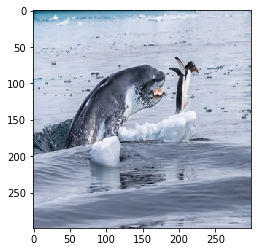

a dog is swimming in the water with a dog .

a dog is swimming in the water as a dog looks on .
a white dog with a surfboard in the water .
a large white dog is playing with a yellow frisbee .
a dog is catching a white frisbee in the water .
a white dog is swimming in the water
a dog is surfing in the ocean on a sunny day .
a person on a surfboard riding a wave .
a dog is surfing in the water at the beach .
a dog is swimming in a wet suit next to a white surfboard .
a dog is in the water with a frisbee in the background .


In [52]:
# !wget https://cdn.shazoo.ru/369556_UAvU5v3gty_1.jpg -O data/test/image7.jpg
image, captions = generate_captions(network.cuda(), inception, 'data/test/image7.jpg', t=2.)
plt.imshow(image)
plt.show()
print(captions)

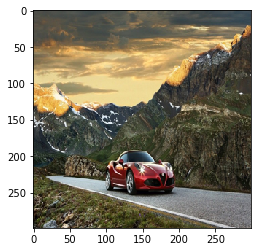

a car parked on a side of a road .

a car parked in the middle of a road .
a car is parked on the side of a road .
a car parked in a grassy field with mountains in the background .
a car parked along the side of a mountain .
a car parked on a side of road with mountains in the background .
a car parked on the side of a road .
a car parked on a road with a mountain in the background .
a car parked on a rural road in front of a mountain .
a motorcycle parked on the side of a road
a car parked on a road next to a mountain


In [54]:
# !wget https://avatars.mds.yandex.net/get-pdb/750514/bab3e4e2-6c10-46f8-a9d8-f7729f7b1b1b/s1200?webp=false -O data/test/image8.jpg
image, captions = generate_captions(network.cuda(), inception, 'data/test/image8.jpg', t=2.)
plt.imshow(image)
plt.show()
print(captions)

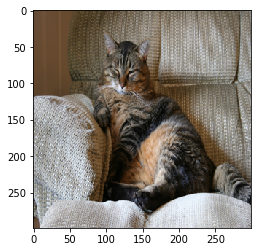

a cat laying on a couch with a remote control .

a cat laying on a couch with a pillow .
a cat is laying on a couch next to a couch .
two cats are laying down on a chair .
a cat laying on a couch with a blanket .
a cat sitting on a couch with a remote control .
a brown and white cat laying on a couch .
a cat laying on a couch with a remote control .
a cat is laying on a couch and chair .
a tabby cat laying on top of a sofa .
a cat laying on a couch next to a couch


In [59]:
# !wget https://www.zastavki.com/pictures/originals/2013/Animals___Cats__fat_cat_043905_.jpg -O data/test/image9.jpg
image, captions = generate_captions(network.cuda(), inception, 'data/test/image9.jpg', t=2.)
plt.imshow(image)
plt.show()
print(captions)

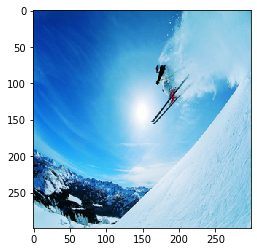

a person on a snowboard in the air .

a group of skiers standing on a hill on a clear day .
a person on a snowboard in the air .
a skier is making a jump into the air .
a person riding a snowboard on top of a snow covered slope .
a group of people on a cloudy day in the air .
a man flying a kite on a cloudy sky .
a skier and a person on a snowboard on a hill .
a skier flies a very big snowy mountain .
a person riding a snowboard down a snowy slope .
a skier flying through the air while riding a snowboard .


In [57]:
# !wget https://wallbox.ru/wallpapers/main/201201/lyzhnik-spusk-skorost-f0280eb.jpg -O data/test/image10.jpg
image, captions = generate_captions(network.cuda(), inception, 'data/test/image10.jpg', t=2.)
plt.imshow(image)
plt.show()
print(captions)

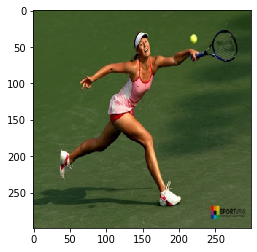

a woman in a white dress playing tennis .

a woman is playing tennis on a clay court .
a woman is playing tennis on a tennis court
a woman is playing tennis on a tennis court .
a woman tennis player in action on the court .
a woman in a white shirt is playing tennis .
a woman tennis player is swinging her racket at a tennis ball .
a woman in a white dress playing tennis
a woman holding a tennis racquet on a tennis court .
a lady swinging a tennis racket on a tennis court .
a woman tennis player is swinging her racket .


In [58]:
# !wget https://lh3.googleusercontent.com/proxy/eNql6M_NsNFQ6-UNAqY1DQbxjBzAlJq_g14eRs9MSUz-p2yqcp887NdP5D578W9qQ7YYp4L6v2el7kd6Y5nljae3d45i7SOTQWvHIasLhfZcLswvi-f9pkHxx-h3VRM3XWXq -O data/test/image11.jpg
image, captions = generate_captions(network.cuda(), inception, 'data/test/image11.jpg', t=2.)
plt.imshow(image)
plt.show()
print(captions)

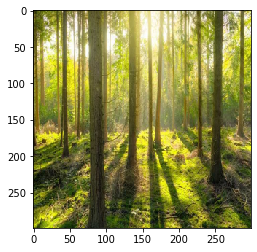

a forest filled with trees and trees in the woods .

a couple of trees that are sitting in the woods
a couple of trees with umbrellas on the ground .
a couple of boats are out in the woods .
a forest filled with trees and purple flowers .
a couple of trees in the woods
a couple of trees that are sitting on a wooded area .
a view of a street with a dog and two dogs in the woods .
a couple of trees with a boat in the woods .
a forest with a couple of trees in the background
a view of a wooded area with trees and trees .


In [64]:
# !wget https://natworld.info/wp-content/uploads/2018/03/Les-letom-900x500.jpg -O data/test/image12.jpg
image, captions = generate_captions(network.cuda(), inception, 'data/test/image12.jpg', t=2.)
plt.imshow(image)
plt.show()
print(captions)

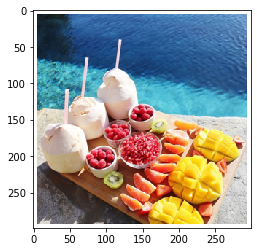

a table with a bunch of different types of fruit

a fruit display with different types of fruit .
a variety of fruit sitting on top of a wooden table .
a display of fruit with fruit and fruit on a wooden surface .
a table full of different types of fruits and vegetables .
a display of fruit and vegetables are sitting on a table .
a bunch of doughnuts are on a table
a display of fruit sitting on a table with a bunch of fruit .
a bunch of fruit sitting on a table
a display of fruit in a box with fruit .
a display of fruits and vegetables sitting on a table


In [72]:
# !wget https://avatars.mds.yandex.net/get-pdb/27625/e03c73c7-fcf9-4740-ba7a-ad33131abcdf/s1200?webp=false -O data/test/image13.jpg
image, captions = generate_captions(network.cuda(), inception, 'data/test/image13.jpg', t=2.)
plt.imshow(image)
plt.show()
print(captions)

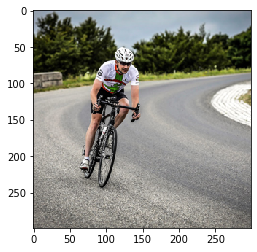

a man riding a bike down a road .

a man riding a bike down the road .
a man on a bike riding his bike in a race .
a man is riding a bike down a road .
a man riding a bike on a road with a dog on the back .
a man riding a bike down the road .
a man riding a bike down the road with a bike in the background .
a man riding a bike on a road near a large rock .
a bike rider on a bicycle in the middle of a road .
a cyclist rides his bicycle in the road .
a man riding a bike down a road next to a bike .


In [76]:
# !wget https://yt3.ggpht.com/a/AATXAJyuEl1t6EamLtYleEqhPyCqRA9Eqxd5ROLPyQ=s900-c-k-c0xffffffff-no-rj-mo -O data/test/image14.jpg
image, captions = generate_captions(network.cuda(), inception, 'data/test/image14.jpg', t=2.)
plt.imshow(image)
plt.show()
print(captions)

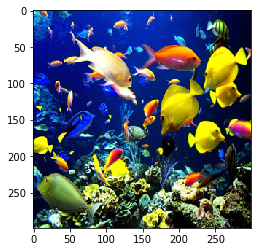

a bunch of colorful kites are sitting on a rack .

a number of colorful kites flying in the sky
a red bird sitting on a tree near a red table .
many red and colorful kites flying in a large group .
a bunch of orange and yellow flowers in a field
a group of colorful kites are sitting on the beach .
many different colored chairs and a red flag hanging from the ceiling .
a group of colorful kites hanging on a red surface .
a bunch of orange and yellow umbrellas on the beach .
many different colored orange and yellow umbrellas and a bunch of different colors
a bunch of colorful kites are sitting on top of a table


In [79]:
# !wget https://avatars.mds.yandex.net/get-zen_doc/198002/pub_5b6462a06ffca100a9c9f505_5b64736775f4b900a936fd9b/scale_1200 -O data/test/image15.jpg
image, captions = generate_captions(network.cuda(), inception, 'data/test/image15.jpg', t=2.)
plt.imshow(image)
plt.show()
print(captions)

### What else to try

If you're made it this far you're awesome and you should know it already. All the tasks below are completely optional and may take a lot of your time. Proceed at your own risk

#### Hard attention

* There are more ways to implement attention than simple softmax averaging. Here's [a lecture](https://www.youtube.com/watch?v=_XRBlhzb31U) on that. 
* We recommend you to start with [gumbel-softmax](https://blog.evjang.com/2016/11/tutorial-categorical-variational.html) or [sparsemax](https://arxiv.org/abs/1602.02068) attention.

#### Reinforcement learning

* After your model has been pre-trained in a teacher forced way, you can tune for captioning-speific models like CIDEr.
* Tutorial on RL for sequence models: [practical_rl week7](https://github.com/yandexdataschool/Practical_RL/tree/spring19/week7_seq2seq)
* Theory: https://arxiv.org/abs/1612.00563

#### Chilling out

This is the final and the most advanced task in the DL course. And if you're doing this with the on-campus YSDA students, it should be late spring by now. There's got to be a better way to spend a few days than coding another deep learning model. If you have no idea what to do, ask Yandex. Or your significant other.

![img](https://imgs.xkcd.com/comics/computers_vs_humans.png)